# Analyzing Trump's Tweets Using Natural Language Processing
There is no doubt that **Donald Trump has been a very controversial and polarizing figure in the United States**, especially since he announced his run for the presidency in 2015.

Throughout his presidency, Donald Trump has used Twitter as a powerful tool to reach his supporters. The social media service has, without a doubt, been one of his most powerful tools.

This project was primarily inspired by Donald Trump's relentless use of Twitter, as it has raised some important questions, including but not limited to:

*   What is the overall sentiment of Trump's tweets, and how has it changed over time?
*   What are some defining features of Trump's behavior on Twitter, and how can we visualize them?

In this project, I will walk you through my analysis of over 50,000 of Donald Trump's tweets using Python and Natural Language Processing (NLP) techniques. Thankfully, [The Trump Archive](https://www.thetrumparchive.com) has provided an open-source API dedicated entirely to Donald Trump's tweets, and we will be using this dataset to perform our analysis today.

As we approach this problem, one cannot help but wonder: to what extent can a NLP algorithm tell us about the meaning and feeling behind a single individual's thoughts, especially when they were, until just recently, limited to 140 characters?

## Setup

### Imports

In [ ]:
# Working with dates
from datetime import datetime as dt
from pytz import timezone

# Data cleaning, analysis
import pandas as pd
import numpy as np

# Data Visualization
import matplotlib as mpl
from matplotlib import pyplot as plt 
import seaborn as sns
%matplotlib inline

# Natural Language Processing
import nltk, re, string
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.corpus import wordnet
from collections import Counter
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')


# VADER Sentiment Analyzer from NLTK
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

# Hide warnings
import warnings
warnings.filterwarnings('ignore')

# Ensure that pandas dataframs are able to print
pd.set_option('display.max_columns', 10)

### Loading the Data

In [ ]:
url = "https://raw.githubusercontent.com/naingthet/trump-tweets-nlp/gh-pages/trump_tweets.csv"
trump_tweets = pd.read_csv(url, parse_dates=True)
print(trump_tweets.head())

                    id                                               text isRetweet isDeleted              device  favorites  retweets                 date
0    98454970654916608  Republicans and Democrats have both created ou...         f         f           TweetDeck         49       255  2011-08-02 18:07:48
1  1234653427789070336  I was thrilled to be back in the Great city of...         f         f  Twitter for iPhone      73748     17404  2020-03-03 01:34:50
2  1218010753434820614  RT @CBS_Herridge: READ: Letter to surveillance...         t         f  Twitter for iPhone          0      7396  2020-01-17 03:22:47
3  1304875170860015617  The Unsolicited Mail In Ballot Scam is a major...         f         f  Twitter for iPhone      80527     23502  2020-09-12 20:10:58
4  1218159531554897920  RT @MZHemingway: Very friendly telling of even...         t         f  Twitter for iPhone          0      9081  2020-01-17 13:13:59


In [ ]:
len(trump_tweets)

55090

In [ ]:
# Creating a deep copy of the dataset in case of contamination or mistakes
trump = trump_tweets.copy(deep=True)

## Utility Functions
We will now create a few utility functions that will be useful later. These functions were originally written as the project was developed, but the code has been placed here in the upfront section for convenience. There are additional utility functions that will be created throughout the project. 

### Graphing Functions

#### date_plotter
This function will allow us to easily create effective graphs for our time series data. 

In [ ]:
def date_plotter(df, x, y, xlabel = None, ylabel = None, title = None, legend = False, labels = None, figsize = None, fmt = 'r-', increments = 'month'):
  # This function will help us to create appealing and effective graphs for our time-series data
  # Input a dataframe and specify x and y columns (x column should contain dates) 
  
  # Preparing the data

  # Save the df as a new variable
  data = df

  # Convert date values to datetime format
  data[x] = data[x].apply(pd.to_datetime)
  # Save the date values to a list
  dates_list = data[x].to_list()
  # Convert list of dates to numerical format; these will be the x values
  dates = mpl.dates.date2num(dates_list)

  # Gathering the y values
  y_list = data[y].to_list()
  y_values = np.array(y_list)

  # Plotting

  # Create figure, axes, and plot
  if figsize == None:
    fig, ax = plt.subplots()
  else:
    fig, ax = plt.subplots(figsize = figsize)
  ax.plot_date(x = dates, y = y_values, fmt = fmt)

  # Formatting dates
  years = mpl.dates.YearLocator()   # every year
  months = mpl.dates.MonthLocator()  # every month
  years_fmt = mpl.dates.DateFormatter('%Y')
  months_fmt = mpl.dates.DateFormatter('%Y-%m')

  # Formatting the ticks by months or years
  # Creating a list of options for increments to ensure proper input
  increment_options = ['month', 'year']
  if increments not in increment_options:
    raise ValueError("Invalid increment type. Expected one of: {}".format(increment_options))
  
  if increments == 'month':
    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(months_fmt)
  elif increments == 'year':
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(years_fmt)

  # Setting x-axis limits  
  datemin = dates[0]
  datemax = dates[-1]
  ax.set_xlim(datemin, datemax)

  # Formatting coordinate grid
  if increments == 'month':
    ax.format_xdata = mpl.dates.DateFormatter('%Y-%m')
  elif increments == 'year':
    ax.format_xdata = mpl.dates.DateFormatter('%Y')
  
  ax.grid(True)

  # X-axis formatting
  fig.autofmt_xdate()

  # Additional formatting
  ax.set_title(title)
  ax.set_xlabel(xlabel)
  ax.set_ylabel(ylabel)
  if legend:
    ax.legend(labels)

  plt.show()

#### date_plotter_sns
This function will operate in a manner very similar to `date_plotter`, but will use the `seaborn` library instead of just `matplotlib`. This function will be used to create sentiment analysis graphs, and is designed to mimic the appearance of the following function, `multiplotter`. 

In [ ]:
def date_plotter_sns(df, x, y, xlabel = None, ylabel = None, title = None, legend = False, labels = None, figsize = None, fmt = 'r-', increments = 'month'):
  # This function will help us to create appealing and effective graphs for our time-series data
  # Input a dataframe and specify x and y columns (x column should contain dates) 
  
  # Preparing the data

  # Save the df as a new variable
  data = df
  color = '#3495eb'

  # Convert date values to datetime format
  data[x] = data[x].apply(pd.to_datetime)
  # Save the date values to a list
  dates_list = data[x].to_list()
  # Convert list of dates to numerical format; these will be the x values
  dates = mpl.dates.date2num(dates_list)

  # Gathering the y values
  y_list = data[y].to_list()
  y_values = np.array(y_list)

  # Plotting

  #Create figure, axes, and plot
  if figsize == None:
    fig, ax = plt.subplots()
  else:
    fig, ax = plt.subplots(figsize = figsize)
  sns.set_theme(style='white')
  sns.lineplot(data = data, x = dates, y = y_values, ax = ax,
               color = color, alpha = 0.5)
  sns.regplot(data = data, x = dates, y = y_values, ax = ax, 
              logistic=True, ci=95, color=color, scatter_kws={'s':5})


  # Formatting dates
  years = mpl.dates.YearLocator()   # every year
  months = mpl.dates.MonthLocator()  # every month
  years_fmt = mpl.dates.DateFormatter('%Y')
  months_fmt = mpl.dates.DateFormatter('%Y-%m')

  # Formatting the ticks by months or years
  # Creating a list of options for increments to ensure proper input
  increment_options = ['month', 'year']
  if increments not in increment_options:
    raise ValueError("Invalid increment type. Expected one of: {}".format(increment_options))
  
  if increments == 'month':
    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(months_fmt)
  elif increments == 'year':
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(years_fmt)

  # Setting x-axis limits  
  datemin = dates[0]
  datemax = dates[-1]
  ax.set_xlim(datemin, datemax)
  ax.set_ylim(-1, 1)

  # Formatting coordinate grid
  if increments == 'month':
    ax.format_xdata = mpl.dates.DateFormatter('%Y-%m')
  elif increments == 'year':
    ax.format_xdata = mpl.dates.DateFormatter('%Y')
  
  ax.grid(False)

  # Creating a black horizontal bar at y = 0, which divides positive and negative sentiments
  ax.axhline(c= 'black')

  # X-axis formatting
  fig.autofmt_xdate()

  # Additional formatting
  ax.set_title(title)
  ax.set_xlabel(xlabel)
  ax.set_ylabel(ylabel)
  if legend:
    ax.legend(labels)
  # ax.spines['right'].set_visible(False)
  # ax.spines['top'].set_visible(False)

  plt.show()

#### multiplotter
This function has a very specific purpose: to create three graphs representing the proportions of positive, neutral, and negative VADER scores.

In [ ]:
def multiplotter(df, x, y, xlabel = 'Date',
                 ylabel = ['Positive Sentiment', 'Neutral Sentiment', 'Negative Sentiment'],
                 title = None, labels = ['Positive', 'Neutral', 'Negative'],
                 figsize = None, increments = 'year'):
  # This function will help us to create appealing and effective graphs for our time-series data
  # Input a dataframe and specify x and y columns (x column should contain dates) 
  
  fig, ax = plt.subplots(3, 1, figsize=(12,8), gridspec_kw={'hspace':0.1}, sharex=True)
  fig.suptitle('Daily Average of Tweet Sentiment')
  # fmt = ['g-', 'b-', 'r-']
  # Alternatives: '#52ff52', '#5252ff', '#ff5050'
  colors = ['g', 'b', 'r']
  xlabels = ['Date', 'Date', 'Date']
  ylabels = ['Positive Sentiment (Proportion)', 'Neutral Sentiment (Proportion)', 'Negative Sentiment (Proportion)']
  
  for i in range(3):
    # Loop variables
    y_it = y[i]
    ax_it = ax[i]

    # Preparing the data

    # Save the df as a new variable
    data = df
    plt.axhline(c='black')
    # Convert date values to datetime format
    data[x] = data[x].apply(pd.to_datetime)
    # Save the date values to a list
    dates_list = data[x].to_list()
    # Convert list of dates to numerical format; these will be the x values
    dates = mpl.dates.date2num(dates_list)

    # Gathering the y values
    y_list = data[y_it].to_list()
    y_values = np.array(y_list)

    # Plotting

    # Create figure, axes, and plot
    sns.set_theme(style='white')
    sns.lineplot(data = data, x = dates, y = y_values, ax = ax_it,
                 color = colors[i], alpha = 0.5)
    sns.regplot(data = data, x = dates, y = y_values, ax = ax_it, 
                logistic=True, ci=95, color=colors[i], scatter_kws={'s':5})
    # ax_it.plot_date(x = dates, y = y_values, fmt = fmt[i])

    # Formatting dates
    years = mpl.dates.YearLocator()   # every year
    months = mpl.dates.MonthLocator()  # every month
    years_fmt = mpl.dates.DateFormatter('%Y')
    months_fmt = mpl.dates.DateFormatter('%Y-%m')

    # Formatting the ticks by months or years
    # Creating a list of options for increments to ensure proper input
    increment_options = ['month', 'year']
    if increments not in increment_options:
      raise ValueError("Invalid increment type. Expected one of: {}".format(increment_options))
  
    if increments == 'month':
      ax_it.xaxis.set_major_locator(months)
      ax_it.xaxis.set_major_formatter(months_fmt)
    elif increments == 'year':
      ax_it.xaxis.set_major_locator(years)
      ax_it.xaxis.set_major_formatter(years_fmt)

    # Setting axis limits  
    datemin = dates[0]
    datemax = dates[-1]
    y_min = 0.0
    y_max = 1.0
    # y_min = y_values.min()
    # y_max = y_values.max()
    ax_it.set_xlim(datemin, datemax)
    ax_it.set_ylim(y_min, y_max)

    # Formatting coordinate grid
    if increments == 'month':
      ax_it.format_xdata = mpl.dates.DateFormatter('%Y-%m')
    elif increments == 'year':
      ax_it.format_xdata = mpl.dates.DateFormatter('%Y')

    # Removing outer spines
    if i == 2: 
      ax_it.spines['right'].set_visible(False)
      ax_it.spines['top'].set_visible(False)
    else:
      ax_it.spines['right'].set_visible(False)
      ax_it.spines['top'].set_visible(False)
      ax_it.spines['bottom'].set_visible(False)

    # Axis formatting
    fig.autofmt_xdate()

    # Additional formatting
    #ax_it.set_title(title)
    ax_it.set_xlabel(xlabel)
    ax_it.set_ylabel(ylabel[i])
    

  plt.show()

## Visualization Setup

In [ ]:
# Matplotlib parameters
mpl.rcParams['figure.figsize'] = [12,6]
mpl.rcParams['font.size'] = 120

# Seaborn setup
sns.set_theme(context='poster' , style='whitegrid')
sns.set(rc={'figure.figsize':(12, 6)})

## Data Cleaning

### Working with dates
First, we will convert the date information into datetime format to make analysis easier

In [ ]:
# Creating a function to change strings to datetime format
fmt = '%Y-%m-%d %H:%M:%S'
def create_dt(date):
    return dt.strptime(date, fmt)

# Creating a new column in the dataframe with datetime objects
trump['datetime'] = trump.date.apply(lambda x: create_dt(x))

Let's look at an example.

In [ ]:
date_ex = trump.datetime[0]
print(date_ex)

2011-08-02 18:07:48


Since all of the dates are in UTC time, we need to convert them to EST. The pytz library will help us do this

In [ ]:
def to_est(date):
  date_utc = date.replace(tzinfo=timezone('UTC'))
  date_est = date_utc.astimezone(timezone('US/Eastern'))
  return date_est

Now we can apply the function we created to create a new column with the local/eastern time

In [ ]:
trump['date_est'] = trump.datetime.apply(lambda x: to_est(x))
print(trump['date_est'].head())

0   2011-08-02 14:07:48-04:00
1   2020-03-02 20:34:50-05:00
2   2020-01-16 22:22:47-05:00
3   2020-09-12 16:10:58-04:00
4   2020-01-17 08:13:59-05:00
Name: date_est, dtype: datetime64[ns, US/Eastern]


In [ ]:
# Dropping the UTC columns and renaming the date_est column as 'date'
trump = trump.drop(['date', 'datetime'], axis = 1)
trump = trump.rename(columns = {'date_est':'date'})

Now that we have processed the dates, we can use it to create a additional columns that contain information such as day of week and month. This will allow us to analyze data based on certain periods of time.

In [ ]:
trump['date_dmy'] = trump['date'].apply(lambda x: x.strftime("%Y-%m-%d")) 
trump['date_my'] = trump['date'].apply(lambda x: x.strftime("%Y-%m")) 
trump['time'] = trump['date'].apply(lambda x: x.strftime("%H:%M"))
trump['hour'] = trump['date'].apply(lambda x: x.strftime("%H"))
trump['day_of_week'] = trump['date'].apply(lambda x: x.strftime("%A"))
trump['year'] = trump['date'].apply(lambda x: x.strftime("%Y"))
trump['month'] = trump['date'].apply(lambda x: x.strftime("%m"))
print(trump.head())

                    id                                               text isRetweet isDeleted              device  ...   time  hour day_of_week  year month
0    98454970654916608  Republicans and Democrats have both created ou...         f         f           TweetDeck  ...  14:07    14     Tuesday  2011    08
1  1234653427789070336  I was thrilled to be back in the Great city of...         f         f  Twitter for iPhone  ...  20:34    20      Monday  2020    03
2  1218010753434820614  RT @CBS_Herridge: READ: Letter to surveillance...         t         f  Twitter for iPhone  ...  22:22    22    Thursday  2020    01
3  1304875170860015617  The Unsolicited Mail In Ballot Scam is a major...         f         f  Twitter for iPhone  ...  16:10    16    Saturday  2020    09
4  1218159531554897920  RT @MZHemingway: Very friendly telling of even...         t         f  Twitter for iPhone  ...  08:13    08      Friday  2020    01

[5 rows x 15 columns]


## Exploratory Data Analysis and Visualization
Next, we will go through each of the non-tweet variables in the dataset and explore them. We will devote a substantial part of our project to this section, in hopes that we can uncover patterns in Donald Trump's tweet activity.

To start, let's look at the distribution of Trump's tweets over time. 

### Tweets per Month

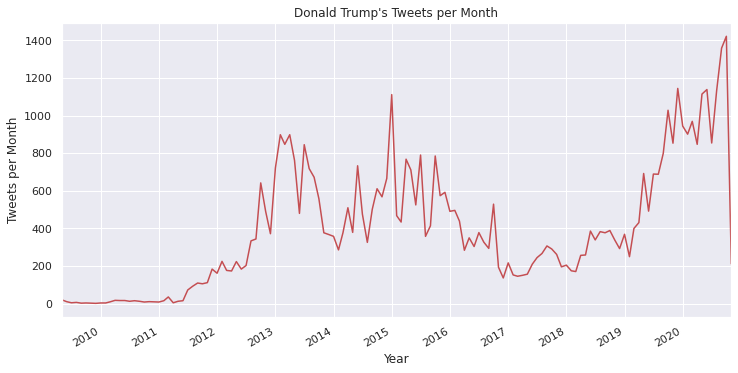

In [ ]:
# Using aggregate functions to determine tweets per month
tweets_my = trump.groupby(trump.date_my).date_my.count()
tweets_my = pd.DataFrame({'date_my':tweets_my.index, 'count':tweets_my.values})
tweets_my

# Using the custom plotting function
date_plotter(tweets_my, 'date_my', 'count', xlabel='Year', ylabel='Tweets per Month', title = "Donald Trump's Tweets per Month", increments='year')

**Note:** Although the x-axis labels represent years, both the x and y values represent **monthly** tweets. We have simply labeled the x-axis with years to minimize clutter.

Interestingly, it appears that Trump's Twitter activity was very high between 2013 and 2016, then decreased after the start of his presidency. However, even more interesting is the fact that Trump has steadily increased his activity since the start of 2019, and is now sending more tweets per month than ever before!

It is important to note that the most recent data shows a drop in monthly tweets, but this is due to the fact that this data was collected about halfway through November 2020. We can therefore disregard this drop.


### Tweets per Day

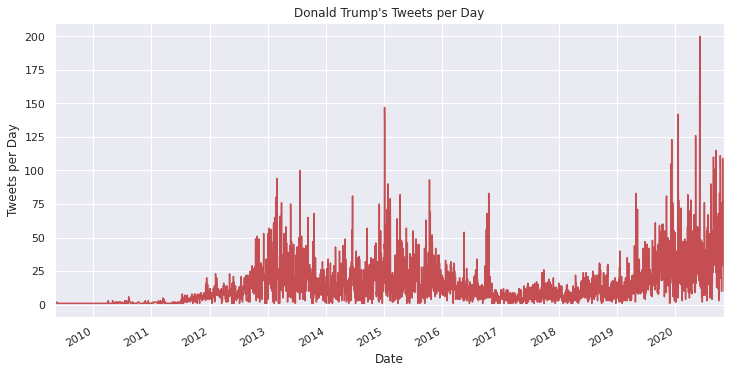

In [ ]:
# Using aggregate functions to determine tweets per day
tweets_day = trump.date_dmy.groupby(trump.date_dmy).count()
tweets_day = pd.DataFrame({'date_dmy':tweets_day.index, 'count':tweets_day.values})
tweets_day

# Using the custom plotting function
date_plotter(tweets_day, 'date_dmy', 'count', xlabel = 'Date', ylabel= 'Tweets per Day', title="Donald Trump's Tweets per Day", increments='year')

Looking at Trump's tweets per day, we see a very similar trend (as we would expect). However, the daily tweet counts provide more granular insight into Trump's behavior on Twitter. We can see that Trump's tweet count can vary significantly from day to day, as there are handful of days on which he sent out more than 100 tweets.

**I know what you're thinking at this point: that must be an error! 200 tweets in one day? Let's take a look at this day in particular and see what we find.** 

In [ ]:
busiest_day = trump.date_dmy.value_counts().index[0]
most_tweets_day = trump.date_dmy.value_counts().values[0]
print("Trump's Busiest Day on Twitter: {} Tweets on {}".format(most_tweets_day, busiest_day))

Trump's Busiest Day on Twitter: 200 Tweets on 2020-06-05


Turns out, on June 5th, 2020, Donald Trump actually tweeted 200 times! Check out this article from [Insider](https://www.insider.com/trump-breaks-record-most-tweets-in-a-single-day-2020-6).

### Tweets by Day of the Week

In [ ]:
# Using pandas aggregates to count total tweets by day of week
tweets_by_day = trump.day_of_week.groupby(trump.day_of_week).count()
tweets_by_day = tweets_by_day.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
tweets_by_day = pd.DataFrame({'day_of_week': tweets_by_day.index, 'count': tweets_by_day.values})
print(tweets_by_day)

  day_of_week  count
0      Monday   8197
1     Tuesday   9077
2   Wednesday   8799
3    Thursday   8270
4      Friday   8236
5    Saturday   6350
6      Sunday   6161


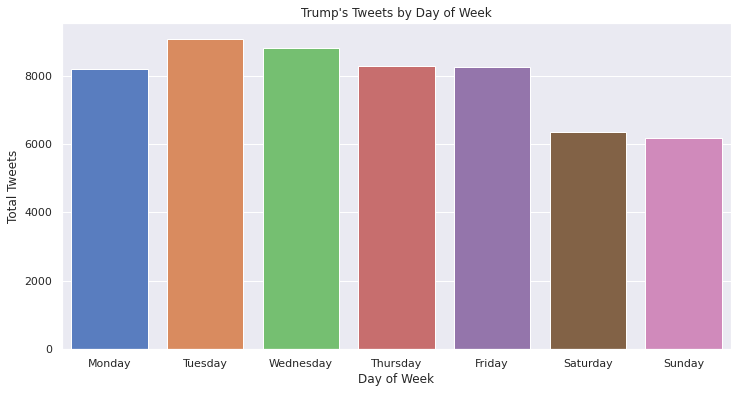

In [ ]:
# We will use seaborn to construct a bar graph
p = sns.barplot(data=tweets_by_day, x = 'day_of_week', y='count', palette='muted')
p.set_xlabel('Day of Week')
p.set_ylabel('Total Tweets')
p.set_title("Trump's Tweets by Day of Week")
plt.show()

It appears that Trump tweets more during the week, but aside from this we are not learning much from this visualization. Let's try to see if we can find more valuable insights by adding hour of day into this analysis.

We will pivot the data so that we can see the frequency of tweets based on day of the week and hour of day. This will give us a visual representation of when Donald Trump likes to tweet.

In [ ]:
# Preparing data for heatmap
# Grouping by day of week and hour
day_hour = trump.id.groupby([trump.day_of_week, trump.hour]).count().reset_index()
# Create a pivot table to call aggregate sum function
day_hour = pd.pivot_table(day_hour, values = 'id', index = 'day_of_week', columns = 'hour', aggfunc='sum')
day_hour = day_hour.reindex((['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']))

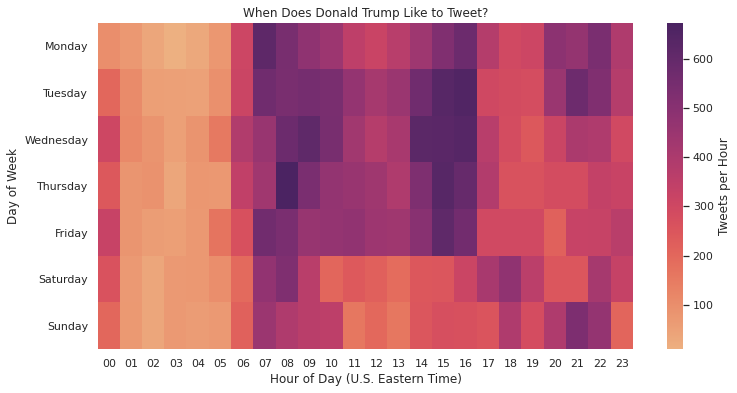

In [ ]:
p = sns.heatmap(data = day_hour, cbar_kws={'label': 'Tweets per Hour'}, cmap='flare')
p.set_title("When Does Donald Trump Like to Tweet?")
p.set_xlabel('Hour of Day (U.S. Eastern Time)')
p.set_ylabel('Day of Week')
plt.show()

This is more interesting. It appears that Trump does most of his tweeting during the work week and between the hours of 7 AM and 4 PM. This heatmap helps us to visualize the density of the tweet activity within this period, but it also shows us that aside from the early hours of the morning, Trump is generally quite active. 

It is clear from our heatmap that Donald Trump does most of his tweeting during the workday. From these insights, I cannot help but ask: how does Donald Trump manage to get any work done? 

### Deleted Tweets
How often does Donald delete his tweets? 

In [ ]:
deleted_tweets = trump.groupby(['isDeleted']).id.count()
deleted_tweets = pd.DataFrame({'status': ['False', 'True'], 'count':deleted_tweets.values})
print(deleted_tweets)

  status  count
0  False  54050
1   True   1040


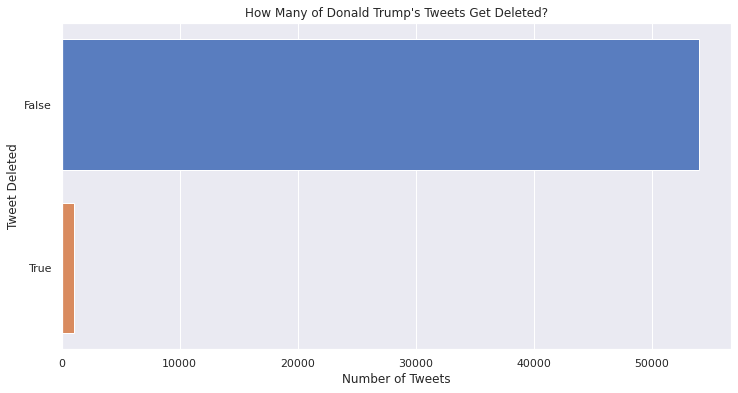

In [ ]:
p = sns.barplot(data = deleted_tweets, x = 'count', y = 'status', orient='h', palette='muted')
p.set_title("How Many of Donald Trump's Tweets Get Deleted?")
p.set_xlabel('Number of Tweets')
p.set_ylabel('Tweet Deleted')
plt.show()

### Deleted Tweets over Time

In [ ]:
# Creating a pivot table so that we can aggregate data based on month of tweet and whether the tweet has been deleted
deleted_df = trump.groupby(['isDeleted', 'date_my']).id.count().reset_index()
deleted_df = pd.pivot_table(data = deleted_df, index='date_my', columns='isDeleted', values = 'id', aggfunc='sum')
deleted_df = deleted_df.rename(columns={'f':'False', 't':'True'})
print(deleted_df.head())

isDeleted  False  True
date_my               
2009-05     21.0   NaN
2009-06     11.0   NaN
2009-07      5.0   NaN
2009-08      7.0   NaN
2009-09      3.0   NaN


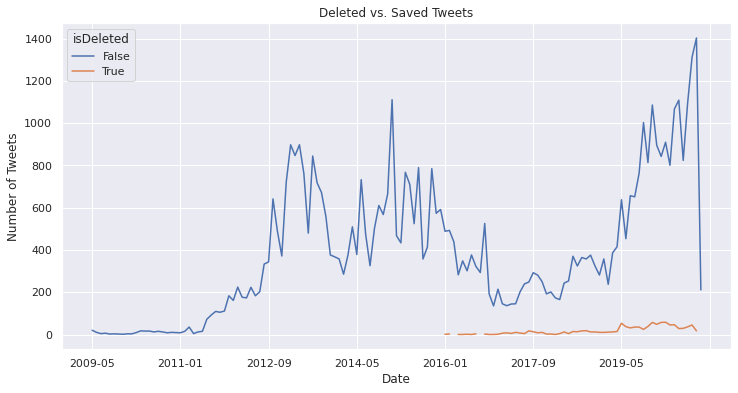

In [ ]:
# Plotting the pivot table using pandas.DataFrame.plot method
p = deleted_df.plot()
p.set_title('Deleted vs. Saved Tweets')
p.set_xlabel('Date')
p.set_ylabel('Number of Tweets')
plt.show()

Interesting! We can now see that it is very rare for Trump to delete his tweets. However, deletions have increased in recent years. This is unsurprising, as presidents have staff and advisors who will encourage them to delete unpopular opinions.

### Retweets

In [ ]:
# Aggregating on retweet column
retweet_df = trump.groupby(['isRetweet', 'date_my']).id.count().reset_index()
retweet_df = pd.pivot_table(data = retweet_df, index='date_my', columns='isRetweet', values = 'id', aggfunc='sum')
retweet_df = retweet_df.rename(columns={'f':'False', 't':'True'})
print(retweet_df.head())

isRetweet  False  True
date_my               
2009-05     21.0   NaN
2009-06     11.0   NaN
2009-07      5.0   NaN
2009-08      7.0   NaN
2009-09      3.0   NaN


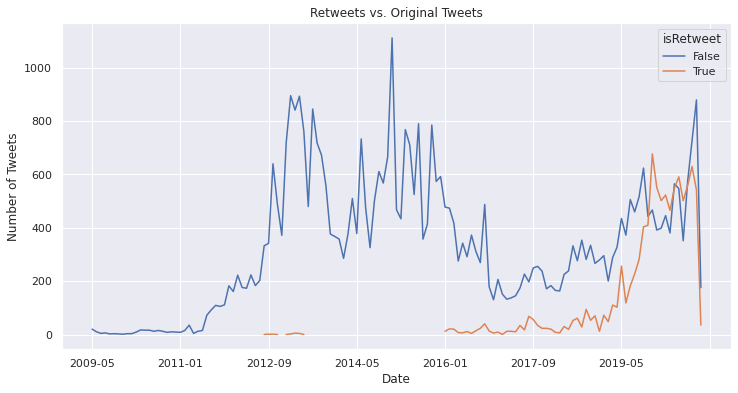

In [ ]:
# Plotting the pivot table using pandas.DataFrame.plot method
p = retweet_df.plot()
p.set_title('Retweets vs. Original Tweets')
p.set_xlabel('Date')
p.set_ylabel('Number of Tweets')
plt.show()

Overall, it appears that the majority of Trump's tweets are original. However, more recently, it appears that Trump retweets roughly as frequently as he writes his own tweets. 

## Applying NLP to Analyze Trump's Tweets



**We will now perform a sentiment analysis using VADER**, a sentiment analysis technique that we will explain shortly. 

Before we begin our analysis, we will separate the tweets into two datasets: original tweets and retweets. As retweets are not written by Trump, we do not want to draw conclusions about Trump's own tweets from his retweets. 

In [ ]:
# Split tweets into original tweets and retweets
original_tweets = trump[trump.isRetweet == 'f']
trump_retweets = trump[trump.isRetweet == 't']
print(original_tweets.shape) # We still have over 45,000 original tweets to analyze!
print(original_tweets.head())

(45755, 15)
                    id                                               text isRetweet isDeleted              device  ...   time  hour day_of_week  year month
0    98454970654916608  Republicans and Democrats have both created ou...         f         f           TweetDeck  ...  14:07    14     Tuesday  2011    08
1  1234653427789070336  I was thrilled to be back in the Great city of...         f         f  Twitter for iPhone  ...  20:34    20      Monday  2020    03
3  1304875170860015617  The Unsolicited Mail In Ballot Scam is a major...         f         f  Twitter for iPhone  ...  16:10    16    Saturday  2020    09
6  1315779944002199552  “I’m running as a proud Democrat, for the Sena...         f         f  Twitter for iPhone  ...  18:22    18      Monday  2020    10
7  1223640662689689602  Getting a little exercise this morning! https:...         f         f  Twitter for iPhone  ...  11:14    11    Saturday  2020    02

[5 rows x 15 columns]


In [ ]:
# Creating variables containing only the tweets
dt_text = original_tweets.text
rt_text = trump_retweets.text

### Cleaning the text data

#### Noise Removal and Tokenization

First, we will clean the text by removing punctuation and other noisy characters. We will also tokenize the strings into individual words

In [ ]:
# Creating a function that we can apply to each row of text
def text_cleaner(text):
  # Use regular expressions to remove punctutation, nonstandard characters, and web links
  text = re.sub(r'[\.\?\!\,\:\;\"\)\(]|https.+|[^(a-zA-Z)\s]', '', text)
  text = text.lower()

  # Tokenize the string into words
  words = word_tokenize(text)
  return words

In [ ]:
dt_tokens = dt_text.apply(text_cleaner)
rt_tokens = rt_text.apply(text_cleaner)

In [ ]:
print(dt_tokens)

0        [republicans, and, democrats, have, both, crea...
1        [i, was, thrilled, to, be, back, in, the, grea...
3        [the, unsolicited, mail, in, ballot, scam, is,...
6        [im, running, as, a, proud, democrat, for, the...
7            [getting, a, little, exercise, this, morning]
                               ...                        
55074    [iran, never, won, a, war, but, never, lost, a...
55078    [thank, you, to, the, dcexaminer, washington, ...
55079    [one, of, my, greatest, honors, was, to, have,...
55088    [just, signed, an, order, to, support, the, wo...
55089    [suburban, women, want, safety, amp, security,...
Name: text, Length: 45755, dtype: object


The first token of every tweet is 'rt'. Let's remove this


In [ ]:
print(rt_tokens)

2        [rt, cbsherridge, read, letter, to, surveillan...
4        [rt, mzhemingway, very, friendly, telling, of,...
5        [rt, whitehouse, president, realdonaldtrump, a...
12                                         [rt, erictrump]
13       [rt, gopchairwoman, the, economic, boom, conti...
                               ...                        
55083    [rt, heatherjones, dear, stupid, people, peace...
55084    [rt, heatherjones, we, have, taken, appropriat...
55085    [rt, randpaul, i, dont, know, why, joebiden, t...
55086    [rt, elisestefanik, president, realdonaldtrump...
55087    [rt, teamtrump, live, presidential, debate, de...
Name: text, Length: 9335, dtype: object


In [ ]:
# Removing the 'rt' tokens
def rt_cleaner(lst):
  lst = lst[1:]
  return lst
rt_tokens = rt_tokens.apply(rt_cleaner)
print(rt_tokens)

2        [cbsherridge, read, letter, to, surveillance, ...
4        [mzhemingway, very, friendly, telling, of, eve...
5        [whitehouse, president, realdonaldtrump, annou...
12                                             [erictrump]
13       [gopchairwoman, the, economic, boom, continues...
                               ...                        
55083    [heatherjones, dear, stupid, people, peace, is...
55084    [heatherjones, we, have, taken, appropriate, f...
55085    [randpaul, i, dont, know, why, joebiden, think...
55086    [elisestefanik, president, realdonaldtrump, ex...
55087    [teamtrump, live, presidential, debate, debate...
Name: text, Length: 9335, dtype: object


#### Further Text Normalization: Lemmatization and Stopword Removal

Next, we will lemmatize the words, effectively bringing them down to their root forms. We will do this instead of stemming, as stemming only removes affixes. To maximize the effectiveness of our lemmatization, we will also tag words with their part of speech (PoS).

At this step, we will further clean and normalize the text data by removing stopwords, which are words that do not provide meaningful information about the statements (in this case, our tweets).

In [ ]:
# Creating a function to pull the PoS for a particular word
def get_pos(word):
  # synsets will return synonyms for the input word, and each synonym will include a part of speech
  pos = wordnet.synsets(word)
  
  # We will now create a Counter() object, in which we will count the PoS tags for each of the synonyms in pos
  pos_counts = Counter()

  # Next, we will pull the PoS of each synonym using the .pos() method
  pos_counts["n"] = len(  [ item for item in pos if item.pos()=="n"]  )
  pos_counts["v"] = len(  [ item for item in pos if item.pos()=="v"]  )
  pos_counts["a"] = len(  [ item for item in pos if item.pos()=="a"]  )
  pos_counts["r"] = len(  [ item for item in pos if item.pos()=="r"]  )
  
  # The most likely PoS is that which has the highest count in pos_counts
  most_likely = pos_counts.most_common(1)[0][0]
  return most_likely

Now that we have created a function that will determine the most likely part of speech for any given word, we can use the output of this function to tag words during lemmatization.

In [ ]:
def text_cleaner_2(words):
  stop_words = stopwords.words('english')
  # Lemmatization with PoS tagging
  lemmatizer = WordNetLemmatizer()
  words = [lemmatizer.lemmatize(word, get_pos(word)) for word in words if word not in stop_words]
  # Stopword removal
  words = [word for word in words if word not in stop_words]
  return words

In [ ]:
dt_tokens_norm = dt_tokens.apply(text_cleaner_2)
rt_tokens_norm = rt_tokens.apply(text_cleaner_2)

In [ ]:
print(dt_tokens_norm.head())

0    [republican, democrat, create, economic, problem]
1    [thrill, back, great, city, charlotte, north, ...
3    [unsolicited, mail, ballot, scam, major, threa...
6    [im, run, proud, democrat, senate, sleepy, joe...
7                     [get, little, exercise, morning]
Name: text, dtype: object


In [ ]:
print(rt_tokens_norm.head())

2     [cbsherridge, read, letter, surveillance, cour...
4     [mzhemingway, friendly, tell, event, comeys, a...
5     [whitehouse, president, realdonaldtrump, annou...
12                                          [erictrump]
13    [gopchairwoman, economic, boom, continue, k, j...
Name: text, dtype: object


We have now finished cleaning our text. Let us now compare a tweet before and after our cleaning.

In [ ]:
print(dt_text[1])

I was thrilled to be back in the Great city of Charlotte, North Carolina with thousands of hardworking American Patriots who love our Country, cherish our values, respect our laws, and always put AMERICA FIRST! Thank you for a wonderful evening!! #KAG2020 https://t.co/dNJZfRsl9y


In [ ]:
print(dt_tokens_norm[1])

['thrill', 'back', 'great', 'city', 'charlotte', 'north', 'carolina', 'thousand', 'hardworking', 'american', 'patriot', 'love', 'country', 'cherish', 'value', 'respect', 'law', 'always', 'put', 'america', 'first', 'thank', 'wonderful', 'evening', 'kag']


As you can see, the text looks very different from its initial state but still manages to convey the meaning of the original tweet.

### N-grams
Before we move on to sentiment analysis, let's take a quick look at the most common N-grams in each of our datasets. N-grams are sequences of N-terms found in the text data, and in this case we will be focusing on bigrams (2-grams) and trigrams (3-grams), as these are able to convey some information about the dataset without being too specific.

In [ ]:
#Unpacking the list of words
dt_words = [item for sublist in dt_tokens_norm.to_list() for item in sublist]
rt_words = [item for sublist in rt_tokens_norm.to_list() for item in sublist]
print(dt_words[:10])

['republican', 'democrat', 'create', 'economic', 'problem', 'thrill', 'back', 'great', 'city', 'charlotte']


In [ ]:
# Creating the bigrams and trigrams
dt_trigrams = (pd.Series(nltk.ngrams(dt_words, 3)).value_counts())[:10]
dt_bigrams = (pd.Series(nltk.ngrams(dt_words, 2)).value_counts())[:10]

rt_trigrams = (pd.Series(nltk.ngrams(rt_words, 3)).value_counts())[:10]
rt_bigrams = (pd.Series(nltk.ngrams(rt_words, 2)).value_counts())[:10]

In [ ]:
# Concatenating bigrams and trigrams to plot on a single graph
dt_ngrams = pd.concat([dt_bigrams, dt_trigrams])
rt_ngrams = pd.concat([rt_bigrams, rt_trigrams])

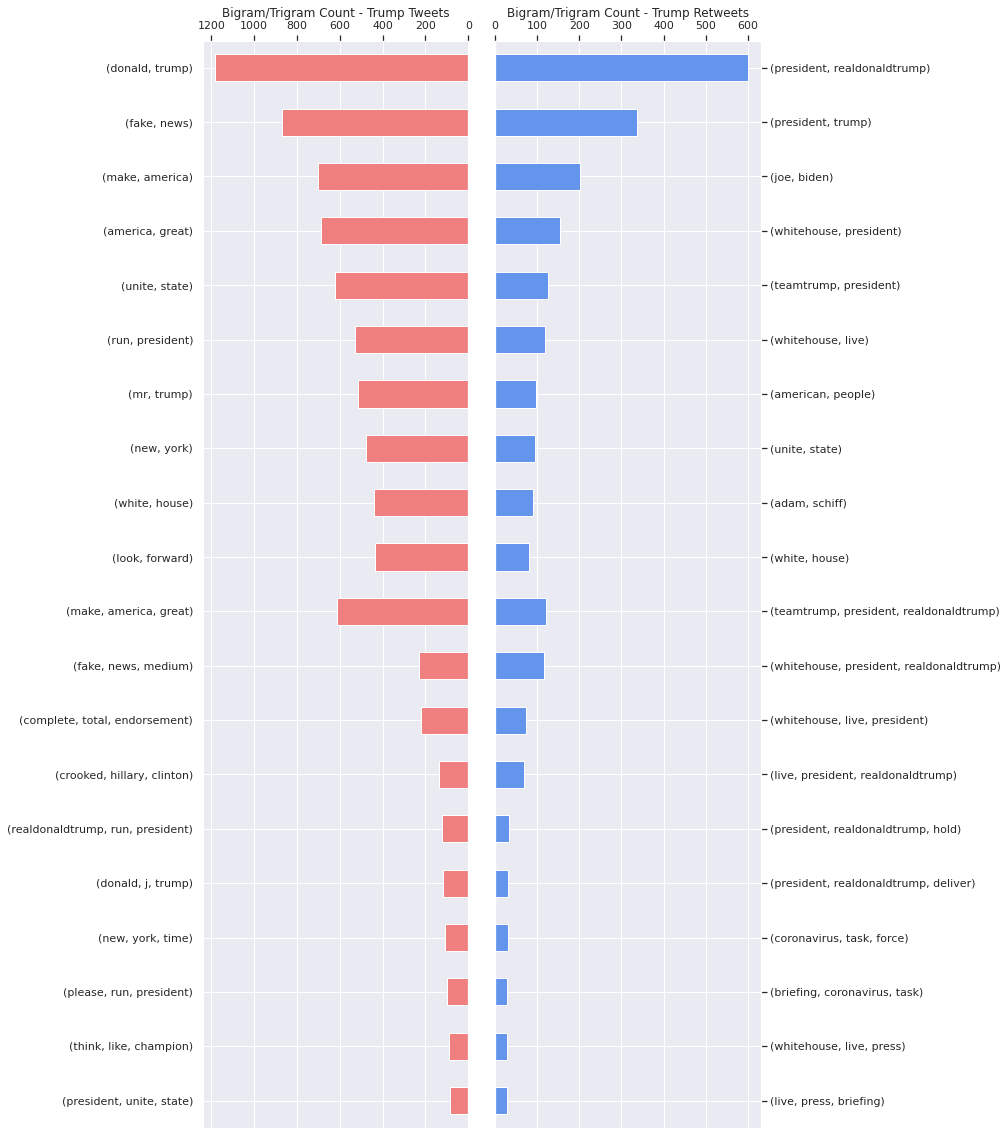

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (10,20), gridspec_kw={'width_ratios':[1,1], 'wspace':0.1, 'hspace':0.1})
bar_ax = ax[0]
dt_ngrams[::-1].plot.barh(ax = bar_ax, color = 'lightcoral')
bar_ax.set_xlim(bar_ax.get_xlim()[::-1])
bar_ax.yaxis.set_label_position("left")
bar_ax.xaxis.tick_top()
bar_ax.xaxis.set_label_position("top")
bar_ax.set_xlabel('Bigram/Trigram Count - Trump Tweets')
bar_ax.set_ylabel('')

bar_ax = ax[1]
rt_ngrams[::-1].plot.barh(ax = bar_ax, color = 'cornflowerblue')
bar_ax.set_xlim(bar_ax.get_xlim())
bar_ax.yaxis.set_label_position("left")
bar_ax.xaxis.tick_top()
bar_ax.yaxis.tick_right()
bar_ax.xaxis.set_label_position("top")
bar_ax.set_xlabel('Bigram/Trigram Count - Trump Retweets')
bar_ax.set_ylabel('')

plt.show()

### VADER Sentiment Analysis
[VADER](https://github.com/cjhutto/vaderSentiment) (**Valence Aware Dictionary and sEntiment Reasoner**) is a sentiment analysis tool that is specifically tuned for the analysis of social media. **VADER works by not only taking into consideration the words that are used in texts (in our case, tweets), but also takes into the context in which words are used to determine whether or not words have a positive, neutral, or negative meaning.** The algorithm also considers use of punctuation, such as exclamation marks, as a factor in determining the degree of a sentiment. 

VADER was specifically developed for the analysis of sentiment in the context of social media, so we can expect it to be one of the most effective tools for this purpose. 

We will use the VADER analysis tool, available through NLTK, to analyze the Trump's sentiment in his tweets over time. 

We will first take a quick look at the sentiment analysis of Trump's entire Twitter archive, but we will then shift our attention to the period from 2015-Present, as it is during this period that Donald Trump has become involved in American politics. 

In [ ]:
# Initialize the VADER sentiment analyzer object
vader_analyzer = SentimentIntensityAnalyzer()

Our goal is to determine the sentiment of each tweet, so we will now create a function that will return the sentiment score for a particular string. We can then apply this function to our pandas dataframes. VADER determines the positivity, neutrality, and negativity of each string (in this case, each tweet) and represents each type of sentiment with a number between 0 and 1. The values are then used to calculate a compound score, where -1 is most negative, 0 is neutral, and +1 is most positive.

In [ ]:
def sentiment_scores(text):
  score = vader_analyzer.polarity_scores(text)
  return score

In [ ]:
# VADER sentiment scores for Trump tweets
original_tweets['polarity_scores'] = original_tweets.text.apply(sentiment_scores) 
original_tweets['vader_compound'] = original_tweets.polarity_scores.apply(lambda x: x['compound'])
original_tweets['vader_neg'] = original_tweets.polarity_scores.apply(lambda x: x['neg'])
original_tweets['vader_neu'] = original_tweets.polarity_scores.apply(lambda x: x['neu'])
original_tweets['vader_pos'] = original_tweets.polarity_scores.apply(lambda x: x['pos'])
print(original_tweets.head())

                    id                                               text isRetweet isDeleted              device  ...                                    polarity_scores  vader_compound vader_neg vader_neu vader_pos
0    98454970654916608  Republicans and Democrats have both created ou...         f         f           TweetDeck  ...  {'neg': 0.231, 'neu': 0.598, 'pos': 0.171, 'co...         -0.1779     0.231     0.598     0.171
1  1234653427789070336  I was thrilled to be back in the Great city of...         f         f  Twitter for iPhone  ...  {'neg': 0.0, 'neu': 0.553, 'pos': 0.447, 'comp...          0.9792     0.000     0.553     0.447
3  1304875170860015617  The Unsolicited Mail In Ballot Scam is a major...         f         f  Twitter for iPhone  ...  {'neg': 0.294, 'neu': 0.706, 'pos': 0.0, 'comp...         -0.9551     0.294     0.706     0.000
6  1315779944002199552  “I’m running as a proud Democrat, for the Sena...         f         f  Twitter for iPhone  ...  {'neg': 0.093, '

In [ ]:
# Grouping sentiment scores by day to get average daily sentiment scores
dt_sentiment_dmy = original_tweets.vader_compound.groupby(original_tweets.date_dmy).mean().reset_index()
dt_sentiment_dmy['date_dmy'] = dt_sentiment_dmy.date_dmy.apply(lambda x: dt.strptime(x, '%Y-%m-%d'))

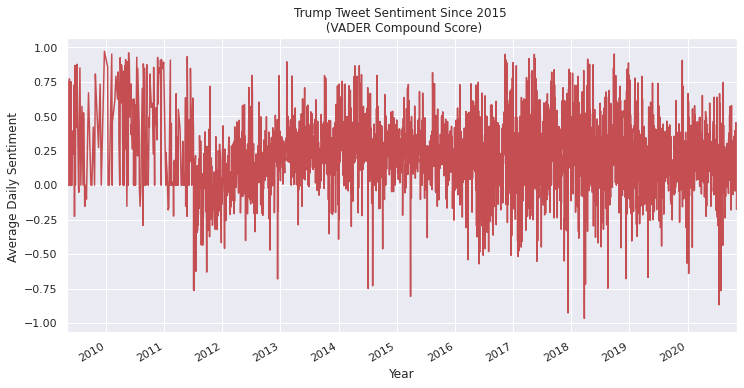

In [ ]:
date_plotter(dt_sentiment_dmy, 'date_dmy', 'vader_compound', increments='year', title = 'Trump Tweet Sentiment Since 2015 \n (VADER Compound Score)', xlabel='Year',ylabel='Average Daily Sentiment ')

#### Presidential Years (2015-Present)

Now that we have analyzed the sentiment of the entire Trump Twitter archive, let's take a more focused look on the past few years, in which Donald Trump has become a political figure. To do so, we will now consider tweets since 2015, as Trump formally announced his first presidential campaign in June of 2015.

In [ ]:
# First, we need to convert the year column to integer type
original_tweets['year'] = pd.to_numeric(original_tweets.year)
# We can now select a subset of the data for the years of interest
presidency_tweets = original_tweets[original_tweets.year >= 2015]
print(presidency_tweets.year.value_counts())

2015    7530
2020    5439
2019    4939
2016    4035
2018    3107
2017    2292
Name: year, dtype: int64


In [ ]:
presidency_tweets_sent = presidency_tweets[['vader_pos', 'vader_neu', 'vader_neg', 'vader_compound']].groupby(presidency_tweets.date_dmy).mean().reset_index()
print(presidency_tweets_sent.describe())

         vader_pos    vader_neu    vader_neg  vader_compound
count  2113.000000  2113.000000  2113.000000     2113.000000
mean      0.176317     0.747679     0.076004        0.204113
std       0.075179     0.073817     0.049175        0.255197
min       0.000000     0.264000     0.000000       -0.966500
25%       0.130625     0.707966     0.041000        0.049460
50%       0.170313     0.750105     0.071833        0.208300
75%       0.217273     0.788600     0.106000        0.363158
max       0.736000     1.000000     0.405000        0.952300


We can now use the function we created earlier to visualize the sentiment over time and assess its trend.

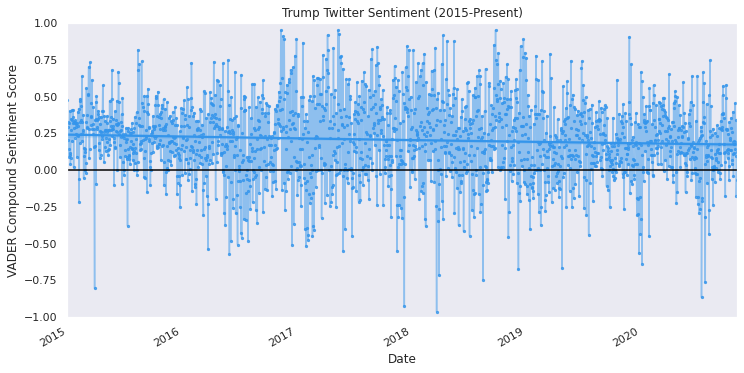

In [ ]:
date_plotter_sns(presidency_tweets_sent, x = 'date_dmy' , y= 'vader_compound', 
                 title='Trump Twitter Sentiment (2015-Present)',
                 xlabel='Date', ylabel='VADER Compound Sentiment Score', increments = 'year')

While our regression curve suggests that Trump's sentiment on Twitter has gradually become more negative, the sentiment remains positive overall. 

#### Positive, Neutral, and Negative VADER Scores
To compute the compound score, VADER gives each text source three scores: positive, neutral, and negative. Each score represents the proportion of the sentiment that is either positive, neutral, or negative, and thus these three scores should add up to 1 for each source. 

In this next section, we will look at the average daily scores of Trump's tweets and use the VADER system to visualize positivity, neutrality, and negativity in the tweets over time. 

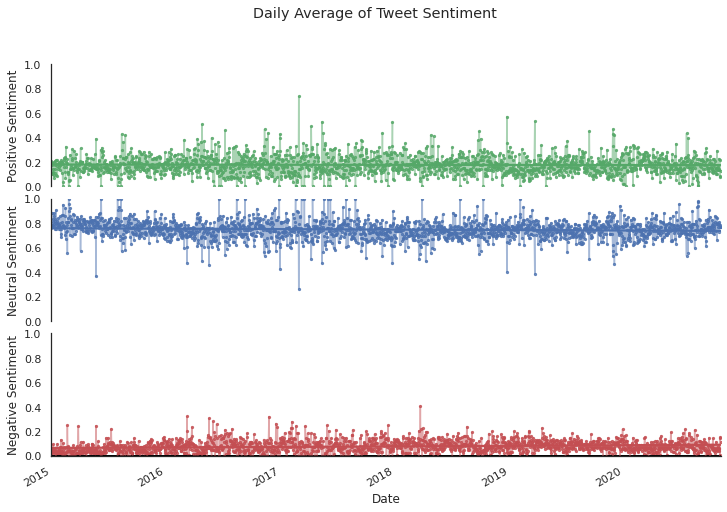

In [ ]:
# We can now use the multiplotter function to create a graph that represents the positive, neutral, and negative sentiments
multiplotter(presidency_tweets_sent, x = 'date_dmy' ,
             y= ['vader_pos', 'vader_neu', 'vader_neg'])

Visualizing the components that make up the VADER component score allows us to see under the hood and understand why Trump's tweets have been labeled as slightly positive overall. 

The data before us suggests that overall, the daily average sentiment is quite neutral. Additionally, the overall probability of tweets being positive or negative is relatively low. 

This, however, does not show us the full picture. Yes, the average is quite neutral, but many tweets are at least moderately positive or negative. Let's use histograms to see the distributions of sentiment scores during Trump's presidency.

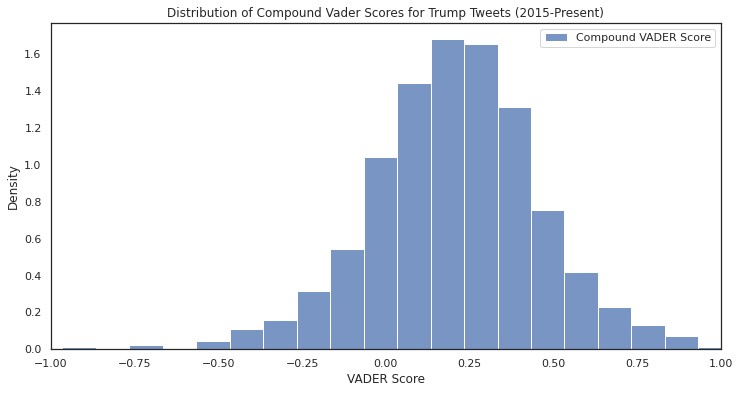

In [189]:
fig, ax = plt.subplots()
sns.histplot(presidency_tweets_sent['vader_compound'], ax=ax, color='b', binwidth=0.10, stat='density')
plt.legend(['Compound VADER Score'])
ax.set_xlabel('VADER Score')
ax.set_xlim(-1,1)
plt.title('Distribution of Compound Vader Scores for Trump Tweets (2015-Present)');

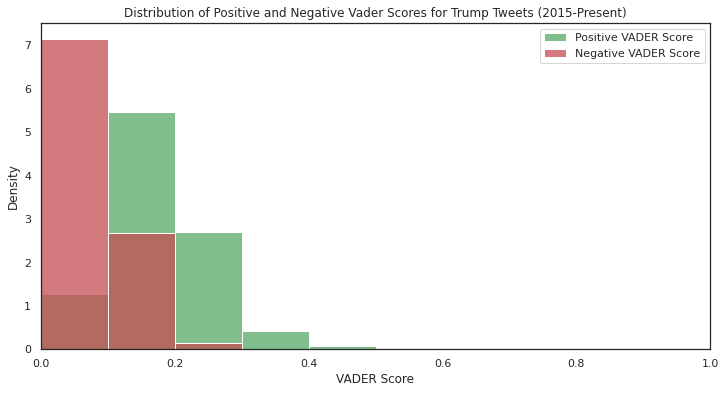

In [188]:
fig, ax = plt.subplots()
sns.histplot(presidency_tweets_sent['vader_pos'], ax=ax, color='g', binwidth=0.10, stat='density')
sns.histplot(presidency_tweets_sent['vader_neg'], ax=ax, color='r', binwidth=0.10, stat='density')
plt.legend(['Positive VADER Score', 'Negative VADER Score'])
ax.set_xlabel('VADER Score')
ax.set_xlim(0,1)
plt.title('Distribution of Positive and Negative Vader Scores for Trump Tweets (2015-Present)');

Our histograms support our findings from our time series analysis, showing that Trump's tweets are generally more positive than they are negative in sentiment. 

## Discussion

### Patterns and Trends
In this project, we performed an in-depth analysis and visualization of Donald Trump's Twitter history to uncover patterns and trends in his activity. We found that, as we expected, Donald Trump is incredibly active on Twitter. Surprisingly, Trump's Twitter use appears to have been highest from 2013-2015, and significantly decreased in the following years. However, in the past 2 years, Trump's Twitter activity has seen a consistent upward trend and is close to his peak activity. 


### Sentiment Analysis 
In addition to data analysis and visualization, we also used the VADER sentiment analysis tool to analyze trends in the sentiment of Donald Trump's Twitter. While individual tweets varied greatly in their sentiment, our analysis found that **over time, Trump's tweets have on average had a slightly positive sentiment.** This is a very interesting finding, as Trump's twitter has been a subject of great controversy, especially during his presidency. Trump has, after all, been accused of [inciting violence through Twitter](https://www.cnn.com/2020/06/23/tech/trump-twitter-violence-warning/index.html) on multiple occasions, and so one would expect that his tweets on the whole have a negative, rather than a positive, sentiment. 

The findings of this project raise interesting questions regarding our benchmarks for sentiment. Yes, VADER showed us that over time, Trump's tweets were generally neutral, even slightly positive. However, we also see that **many of Trump's tweets were negative**. Although the positive is more frequent than the negative, we have to ask ourselves: to what extent can the positive make up for the negative? We can see from the compound scores that some of Trump's tweets were extremely negative, and although these are a minority, they are of greater significance than extremely positive tweets. However, the answer to this question is up for each of us to decide. 

Although much certainly remains to be learned, this analysis helped to provide some insights into the controversial Twitter presence of Donald Trump, and thankfully, turned out to be a very interesting and insightful undertaking.

In [193]:
! jupyter nbconvert --to markdown '/content/drive/MyDrive/Colab Notebooks/Projects/Trump Twitter Analysis/trump_twitter_nlp.ipynb'

[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/Projects/Trump Twitter Analysis/trump_twitter_nlp.ipynb to markdown
[NbConvertApp] Support files will be in trump_twitter_nlp_files/
[NbConvertApp] Making directory /content/drive/MyDrive/Colab Notebooks/Projects/Trump Twitter Analysis/trump_twitter_nlp_files
[NbConvertApp] Making directory /content/drive/MyDrive/Colab Notebooks/Projects/Trump Twitter Analysis/trump_twitter_nlp_files
[NbConvertApp] Making directory /content/drive/MyDrive/Colab Notebooks/Projects/Trump Twitter Analysis/trump_twitter_nlp_files
[NbConvertApp] Making directory /content/drive/MyDrive/Colab Notebooks/Projects/Trump Twitter Analysis/trump_twitter_nlp_files
[NbConvertApp] Making directory /content/drive/MyDrive/Colab Notebooks/Projects/Trump Twitter Analysis/trump_twitter_nlp_files
[NbConvertApp] Making directory /content/drive/MyDrive/Colab Notebooks/Projects/Trump Twitter Analysis/trump_twitter_nlp_files
[NbConvertApp] Making directory